In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import os
import pandas as pd
import re
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from matplotlib.colors import LinearSegmentedColormap



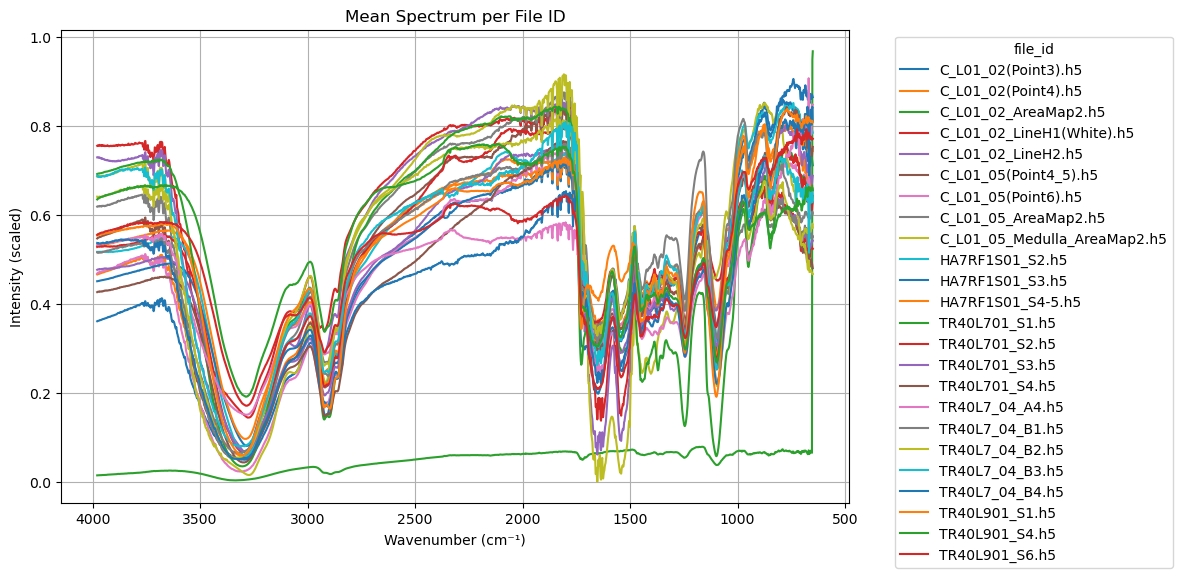

In [3]:
# === 1. Load and plot all spectra ===
file_path = 'spectra_scaled.csv'
df = pd.read_csv(file_path, low_memory=False)

# Extract spectral columns
spectral_columns = [col for col in df.columns if col.replace('.', '', 1).isdigit()]
spectral_data = df[spectral_columns].apply(pd.to_numeric, errors='coerce')

# Plot mean spectra per unique file_id
plt.figure(figsize=(12, 6))
for file_id in df['file_id'].unique():
    subset = df[df['file_id'] == file_id]
    mean_spectrum = subset[spectral_columns].apply(pd.to_numeric, errors='coerce').mean()
    plt.plot([float(w) for w in spectral_columns], mean_spectrum, label=file_id)
plt.title("Mean Spectrum per File ID")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity (scaled)")
plt.gca().invert_xaxis()
plt.legend(title='file_id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# === 2. Filter spectra with strong keratin double peaks (~1650 and 1540 cm⁻¹) ===
spectral_wavenumbers = [float(w) for w in spectral_columns]
closest_1650 = min(spectral_wavenumbers, key=lambda x: abs(x - 1650))
closest_1540 = min(spectral_wavenumbers, key=lambda x: abs(x - 1540))
keratin_cols = [str(closest_1650), str(closest_1540)]
df[keratin_cols[0]] = pd.to_numeric(df[keratin_cols[0]], errors='coerce')
df[keratin_cols[1]] = pd.to_numeric(df[keratin_cols[1]], errors='coerce')
keratin_strength = df[keratin_cols].mean(axis=1)
keratin_threshold = np.percentile(keratin_strength, 75)
df_keratin = df[keratin_strength > keratin_threshold]

In [5]:

# === 3. Further filter for strong 1730 C=O peak (potential cocaine marker) ===
closest_1730 = min(spectral_wavenumbers, key=lambda x: abs(x - 1730))
col_1730 = str(closest_1730)
df_keratin[col_1730] = pd.to_numeric(df_keratin[col_1730], errors='coerce')
threshold_1730 = np.percentile(df_keratin[col_1730], 90)
df_strong = df_keratin[df_keratin[col_1730] > threshold_1730]

# Normalize likelihood based on 1730 peak
df_strong['cocaine_likelihood'] = (
    (df_strong[col_1730] - df_strong[col_1730].min()) /
    (df_strong[col_1730].max() - df_strong[col_1730].min())
)

C:\Users\tssan\AppData\Local\Temp\ipykernel_23720\722709602.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keratin[col_1730] = pd.to_numeric(df_keratin[col_1730], errors='coerce')
C:\Users\tssan\AppData\Local\Temp\ipykernel_23720\722709602.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strong['cocaine_likelihood'] = (


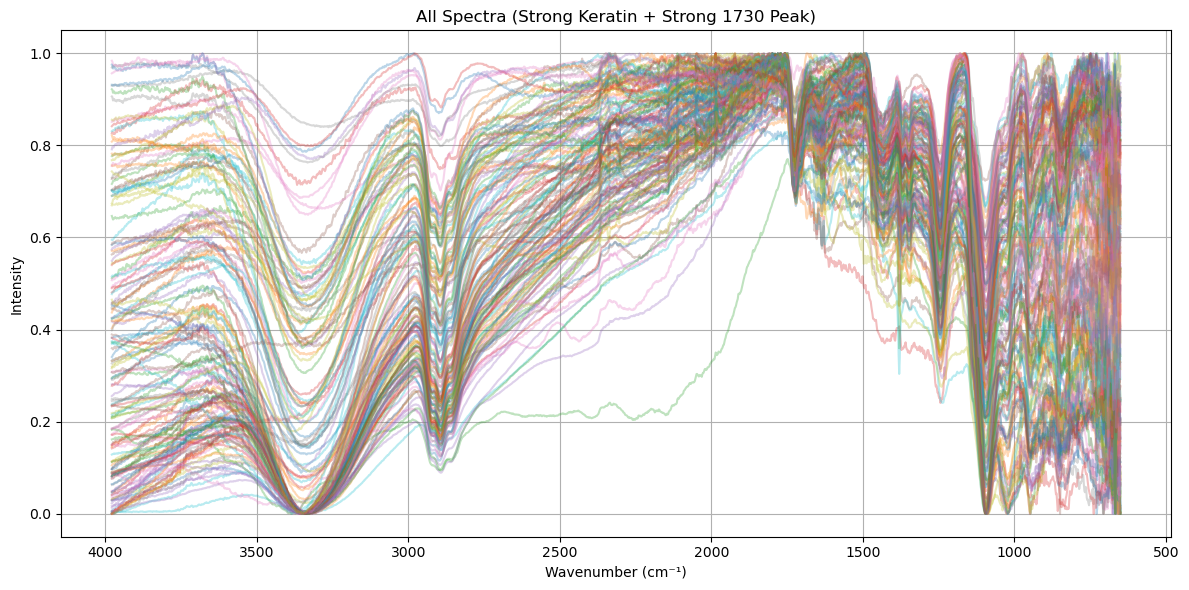

In [6]:

# === 4. Plot all spectra (no mean) and cluster into 5 groups ===
plt.figure(figsize=(12, 6))
for _, row in df_strong.iterrows():
    plt.plot([float(w) for w in spectral_columns], row[spectral_columns].astype(float), alpha=0.3)
plt.title("All Spectra (Strong Keratin + Strong 1730 Peak)")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity")
plt.gca().invert_xaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


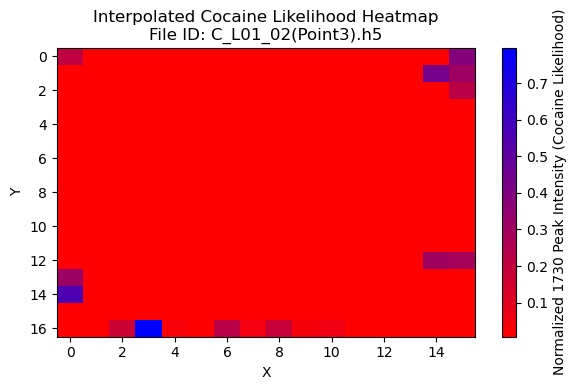

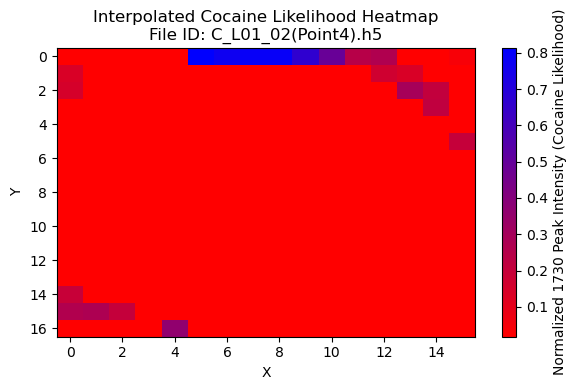

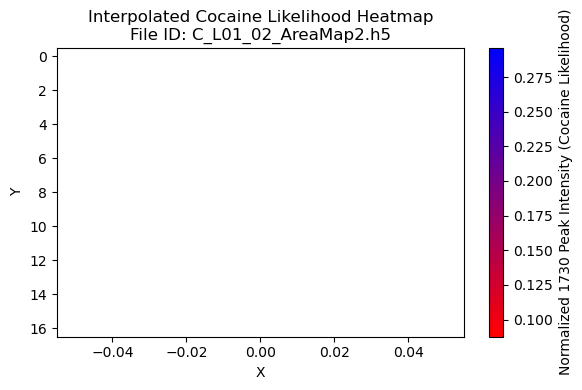

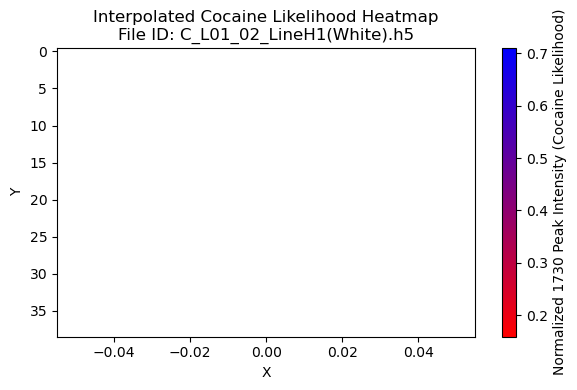

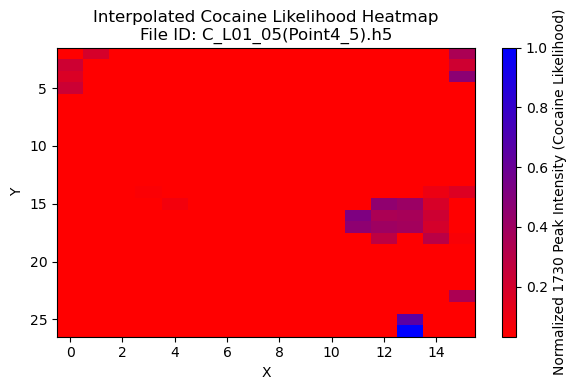

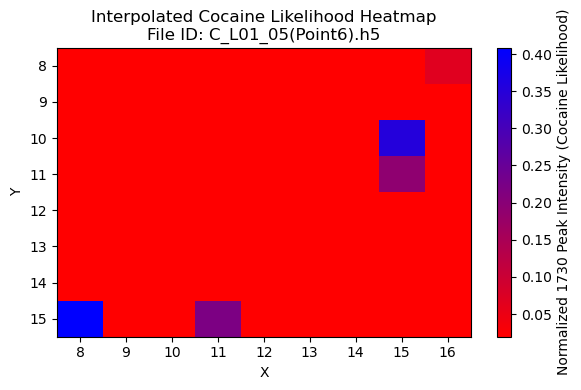

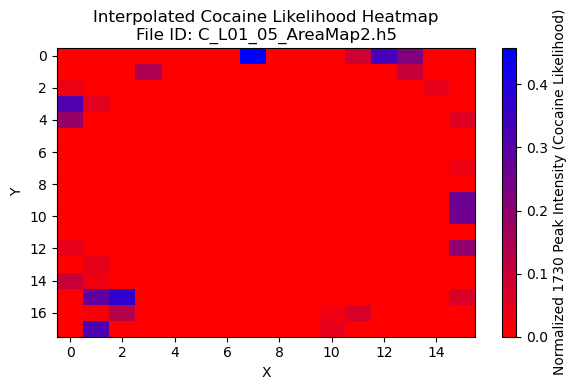

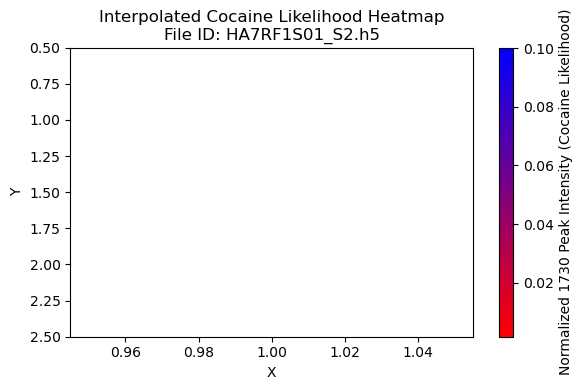

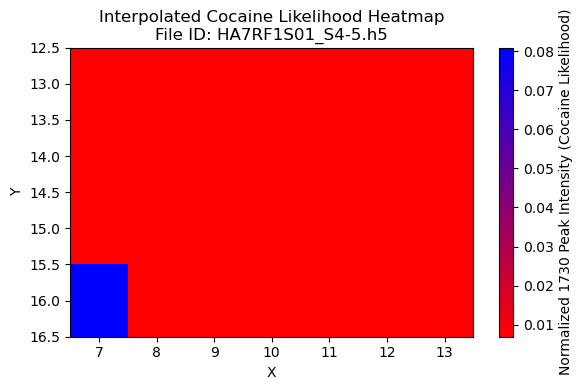

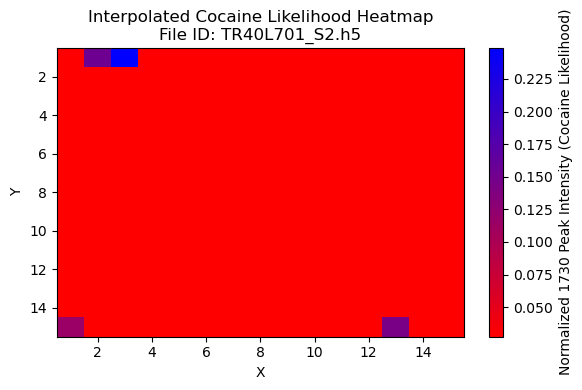

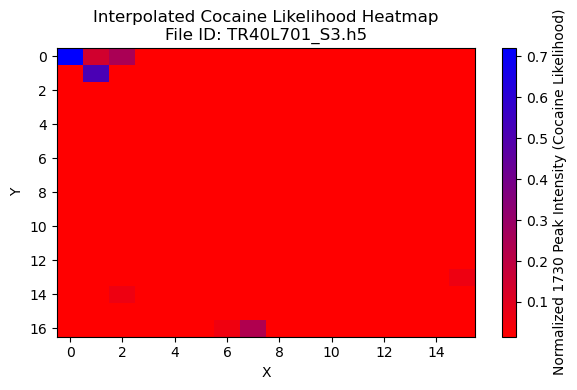

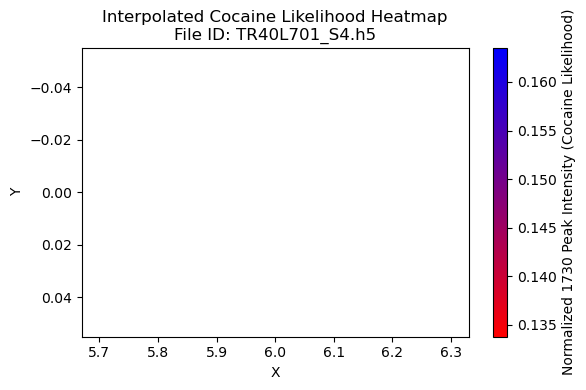

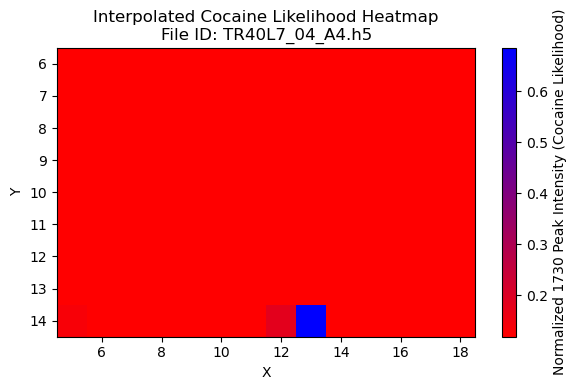

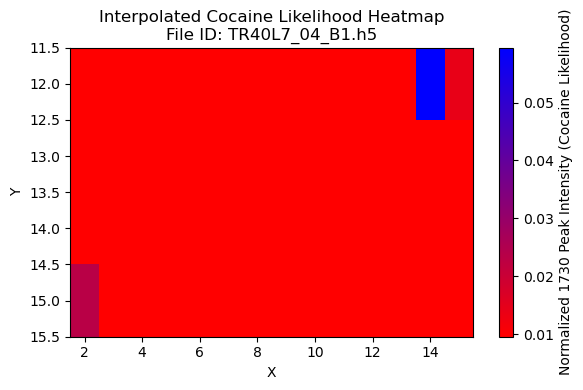

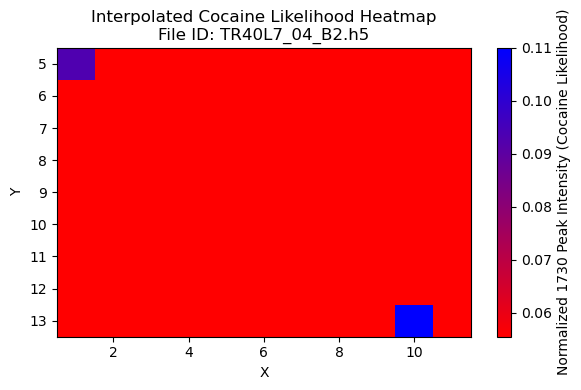

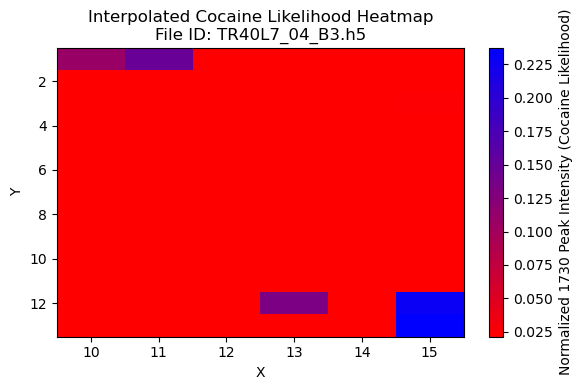

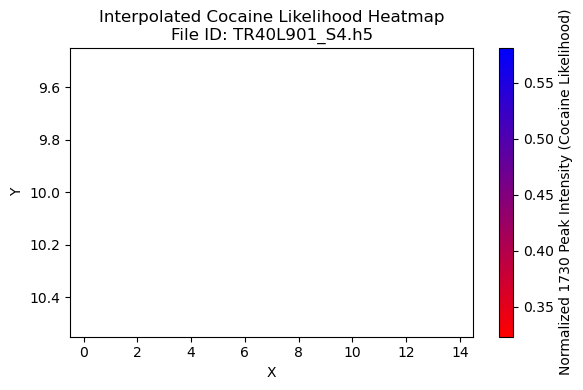

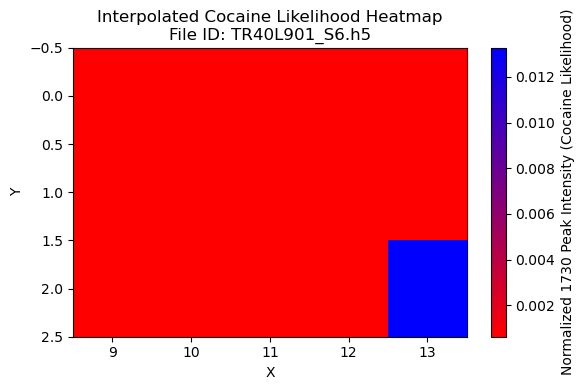

In [7]:

# === 5. Spatial heatmaps per file_id (interpolated, colormap red to blue) ===
# Custom red-to-blue colormap
red_blue_cmap = LinearSegmentedColormap.from_list("red_blue", ["red", "blue"])
grid_spacing = 1 # coarse resolution to reduce memory use

for file_id in df_strong['file_id'].unique():
    subset = df_strong[df_strong['file_id'] == file_id]

    x = subset['x'].astype(int)
    y = subset['y'].astype(int)
    likelihood = subset['cocaine_likelihood']

    x_range = range(x.min(), x.max() + 1, grid_spacing)
    y_range = range(y.min(), y.max() + 1, grid_spacing)
    heatmap = pd.DataFrame(
        np.full((len(y_range), len(x_range)), fill_value=likelihood.min()),
        index=y_range, columns=x_range
    )

    for xi, yi, li in zip(x, y, likelihood):
        gx, gy = xi - xi % grid_spacing, yi - yi % grid_spacing
        if gy in heatmap.index and gx in heatmap.columns:
            heatmap.at[gy, gx] = max(heatmap.at[gy, gx], li)

    plt.figure(figsize=(6, 4))
    hm = plt.pcolormesh(
        heatmap.columns, heatmap.index, heatmap.values,
        shading='auto', cmap=red_blue_cmap
    )
    plt.colorbar(hm, label="Normalized 1730 Peak Intensity (Cocaine Likelihood)")
    plt.title(f"Interpolated Cocaine Likelihood Heatmap\nFile ID: {file_id}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.tight_layout()
    plt.show()


C:\Users\tssan\AppData\Local\Temp\ipykernel_23720\2525914054.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strong[keratin_cols[0]] = pd.to_numeric(df_strong[keratin_cols[0]], errors='coerce')
C:\Users\tssan\AppData\Local\Temp\ipykernel_23720\2525914054.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strong[keratin_cols[1]] = pd.to_numeric(df_strong[keratin_cols[1]], errors='coerce')


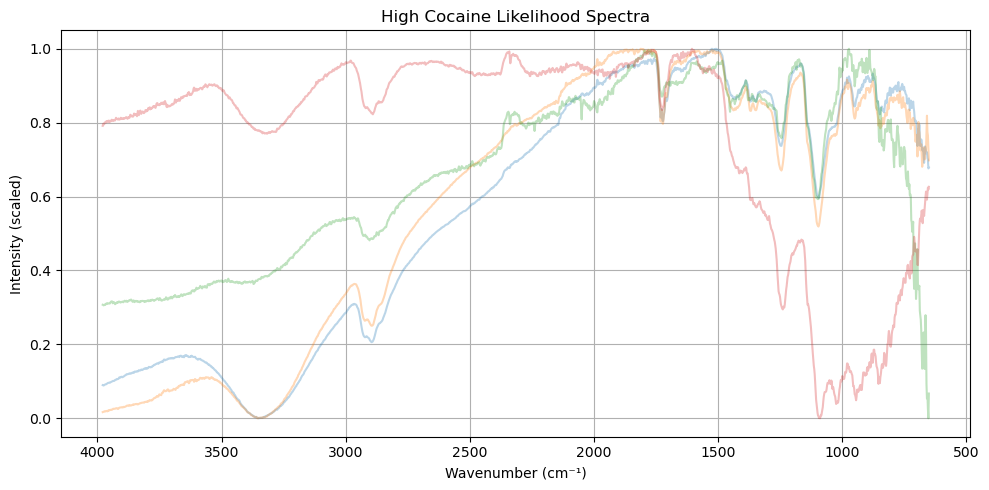

'high_cocaine_likelihood_spectra.csv'

In [9]:
# Recalculate the cocaine likelihood using the user's method

# Extract spectral columns
spectral_columns = [col for col in df_strong.columns if col.replace('.', '', 1).isdigit()]
spectral_wavenumbers = [float(w) for w in spectral_columns]

# Find closest wavenumbers to 1650, 1540, and 1730
closest_1650 = min(spectral_wavenumbers, key=lambda x: abs(x - 1650))
closest_1540 = min(spectral_wavenumbers, key=lambda x: abs(x - 1540))
closest_1730 = min(spectral_wavenumbers, key=lambda x: abs(x - 1730))

# Filter spectra with strong keratin double peaks
keratin_cols = [str(closest_1650), str(closest_1540)]
df_strong[keratin_cols[0]] = pd.to_numeric(df_strong[keratin_cols[0]], errors='coerce')
df_strong[keratin_cols[1]] = pd.to_numeric(df_strong[keratin_cols[1]], errors='coerce')
keratin_strength = df_strong[keratin_cols].mean(axis=1)
keratin_threshold = np.percentile(keratin_strength, 75)
df_keratin = df_strong[keratin_strength > keratin_threshold].copy()

# Filter for strong 1730 peak (C=O, potential cocaine marker)
col_1730 = str(closest_1730)
df_keratin[col_1730] = pd.to_numeric(df_keratin[col_1730], errors='coerce')
threshold_1730 = np.percentile(df_keratin[col_1730], 90)
df_strong = df_keratin[df_keratin[col_1730] > threshold_1730].copy()

# Normalize likelihood
df_strong['cocaine_likelihood'] = (
    (df_strong[col_1730] - df_strong[col_1730].min()) /
    (df_strong[col_1730].max() - df_strong[col_1730].min())
)

# Plot high-likelihood spectra
spectral_data_strong = df_strong[spectral_columns].apply(pd.to_numeric, errors='coerce')
plt.figure(figsize=(10, 5))
for _, row in spectral_data_strong.iterrows():
    plt.plot([float(w) for w in spectral_columns], row, alpha=0.3)
plt.title("High Cocaine Likelihood Spectra")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity (scaled)")
plt.gca().invert_xaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save high likelihood spectra to CSV
output_path = "high_cocaine_likelihood_spectra.csv"
df_strong.to_csv(output_path, index=False)

output_path


c:\Users\tssan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


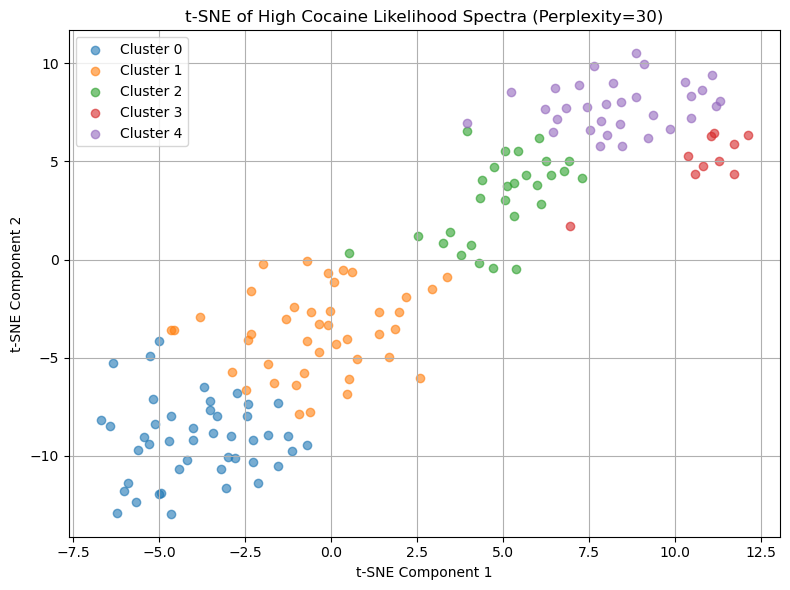

In [12]:
# Re-import after code execution state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Reload the CSV file
csv_path = "spectra_scaled.csv"
df_csv = pd.read_csv(csv_path, low_memory=False)

# Extract spectral columns
spectral_columns = [col for col in df_csv.columns if col.replace('.', '', 1).isdigit()]
spectral_wavenumbers = [float(w) for w in spectral_columns]

# Identify important peak columns
closest_1650 = min(spectral_wavenumbers, key=lambda x: abs(x - 1650))
closest_1540 = min(spectral_wavenumbers, key=lambda x: abs(x - 1540))
closest_1730 = min(spectral_wavenumbers, key=lambda x: abs(x - 1730))
keratin_cols = [str(closest_1650), str(closest_1540)]
col_1730 = str(closest_1730)

# Calculate keratin strength
df_csv[keratin_cols[0]] = pd.to_numeric(df_csv[keratin_cols[0]], errors='coerce')
df_csv[keratin_cols[1]] = pd.to_numeric(df_csv[keratin_cols[1]], errors='coerce')
keratin_strength = df_csv[keratin_cols].mean(axis=1)
keratin_threshold = np.percentile(keratin_strength, 75)
df_keratin = df_csv[keratin_strength > keratin_threshold].copy()

# Filter by 1730 peak intensity
df_keratin[col_1730] = pd.to_numeric(df_keratin[col_1730], errors='coerce')
threshold_1730 = np.percentile(df_keratin[col_1730], 90)
df_strong = df_keratin[df_keratin[col_1730] > threshold_1730].copy()

# Normalize the 1730 peak to compute likelihood
df_strong['cocaine_likelihood'] = (
    (df_strong[col_1730] - df_strong[col_1730].min()) /
    (df_strong[col_1730].max() - df_strong[col_1730].min())
)

# Prepare spectral data
spectral_data = df_strong[spectral_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

# Normalize spectra
scaler = StandardScaler()
spectral_scaled = scaler.fit_transform(spectral_data)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(spectral_scaled)
df_strong['pca_1'] = pca_result[:, 0]
df_strong['pca_2'] = pca_result[:, 1]

# KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
df_strong['cluster'] = kmeans.fit_predict(spectral_scaled)

# Adjusted t-SNE
safe_perplexity = min(30, max(5, len(df_strong) // 3))
tsne = TSNE(n_components=2, perplexity=safe_perplexity, learning_rate=200, random_state=0)
tsne_result = tsne.fit_transform(spectral_scaled)
df_strong['tsne_1'] = tsne_result[:, 0]
df_strong['tsne_2'] = tsne_result[:, 1]

# Plot t-SNE
plt.figure(figsize=(8, 6))
for cluster_id in sorted(df_strong['cluster'].unique()):
    subset = df_strong[df_strong['cluster'] == cluster_id]
    plt.scatter(subset['tsne_1'], subset['tsne_2'], label=f'Cluster {cluster_id}', alpha=0.6)
plt.title(f"t-SNE of High Cocaine Likelihood Spectra (Perplexity={safe_perplexity})")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


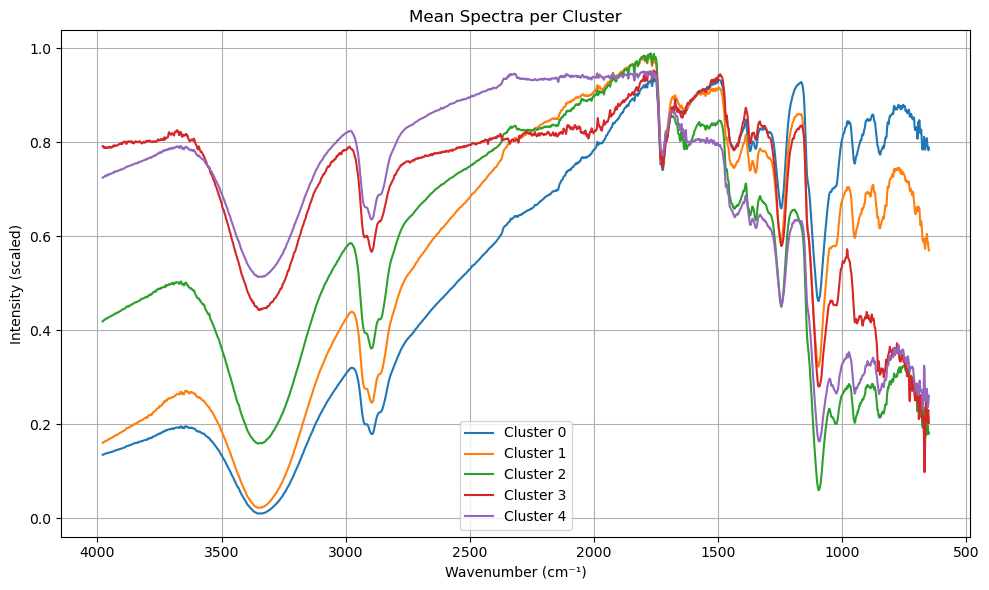

In [13]:
import matplotlib.pyplot as plt

# Make sure spectral_columns is defined
spectral_columns = [col for col in df_strong.columns if col.replace('.', '', 1).isdigit()]
wavenumbers = [float(w) for w in spectral_columns]

# Plot mean spectrum for each cluster
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df_strong['cluster'].unique()):
    cluster_data = df_strong[df_strong['cluster'] == cluster_id]
    mean_spectrum = cluster_data[spectral_columns].apply(pd.to_numeric, errors='coerce').mean()
    plt.plot(wavenumbers, mean_spectrum, label=f'Cluster {cluster_id}')

plt.title("Mean Spectra per Cluster")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity (scaled)")
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



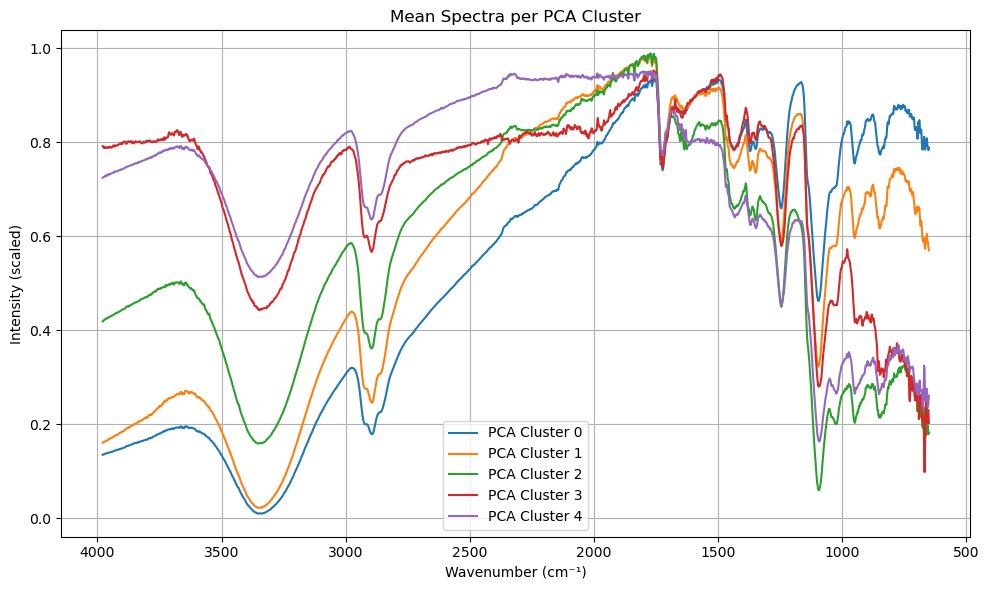

In [14]:
import matplotlib.pyplot as plt

# Plot mean spectrum per PCA cluster
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df_strong['cluster'].unique()):
    cluster_data = df_strong[df_strong['cluster'] == cluster_id]
    mean_spectrum = cluster_data[spectral_columns].apply(pd.to_numeric, errors='coerce').mean()
    plt.plot(wavenumbers, mean_spectrum, label=f'PCA Cluster {cluster_id}')

plt.title("Mean Spectra per PCA Cluster")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity (scaled)")
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\tssan\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\tssan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


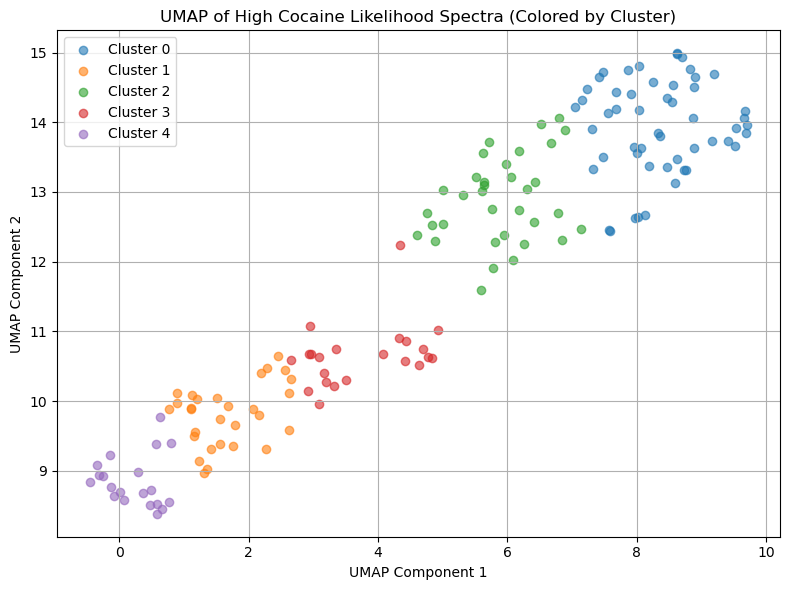

In [19]:
# Import UMAP
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# === 1. Run UMAP ===
umap_model = umap.UMAP(n_components=2, random_state=0)
umap_result = umap_model.fit_transform(spectral_scaled)
df_strong['umap_1'] = umap_result[:, 0]
df_strong['umap_2'] = umap_result[:, 1]

# === 2. Cluster UMAP output ===
kmeans_umap = KMeans(n_clusters=5, random_state=0)
df_strong['umap_cluster'] = kmeans_umap.fit_predict(umap_result)

# === 3. Plot UMAP result by cluster ===
plt.figure(figsize=(8, 6))
for cluster_id in sorted(df_strong['umap_cluster'].unique()):
    subset = df_strong[df_strong['umap_cluster'] == cluster_id]
    plt.scatter(subset['umap_1'], subset['umap_2'], label=f'Cluster {cluster_id}', alpha=0.6)
plt.title("UMAP of High Cocaine Likelihood Spectra (Colored by Cluster)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# === UMAP (Install with: pip install umap-learn) ===
import umap.umap_ as umap
from sklearn.cluster import KMeans

# 1. UMAP reduction
umap_model = umap.UMAP(n_components=2, random_state=0)
umap_result = umap_model.fit_transform(spectral_scaled)
df_strong['umap_1'] = umap_result[:, 0]
df_strong['umap_2'] = umap_result[:, 1]

# 2. Clustering on UMAP
df_strong['umap_cluster'] = KMeans(n_clusters=5, random_state=0).fit_predict(umap_result)


c:\Users\tssan\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\tssan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [21]:
# === Isomap ===
from sklearn.manifold import Isomap

# 1. Isomap reduction
isomap = Isomap(n_components=2)
isomap_result = isomap.fit_transform(spectral_scaled)
df_strong['isomap_1'] = isomap_result[:, 0]
df_strong['isomap_2'] = isomap_result[:, 1]

# 2. Clustering on Isomap
df_strong['isomap_cluster'] = KMeans(n_clusters=5, random_state=0).fit_predict(isomap_result)


c:\Users\tssan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [22]:
# === LLE ===
from sklearn.manifold import LocallyLinearEmbedding

# 1. LLE reduction
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
lle_result = lle.fit_transform(spectral_scaled)
df_strong['lle_1'] = lle_result[:, 0]
df_strong['lle_2'] = lle_result[:, 1]

# 2. Clustering on LLE
df_strong['lle_cluster'] = KMeans(n_clusters=5, random_state=0).fit_predict(lle_result)


c:\Users\tssan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


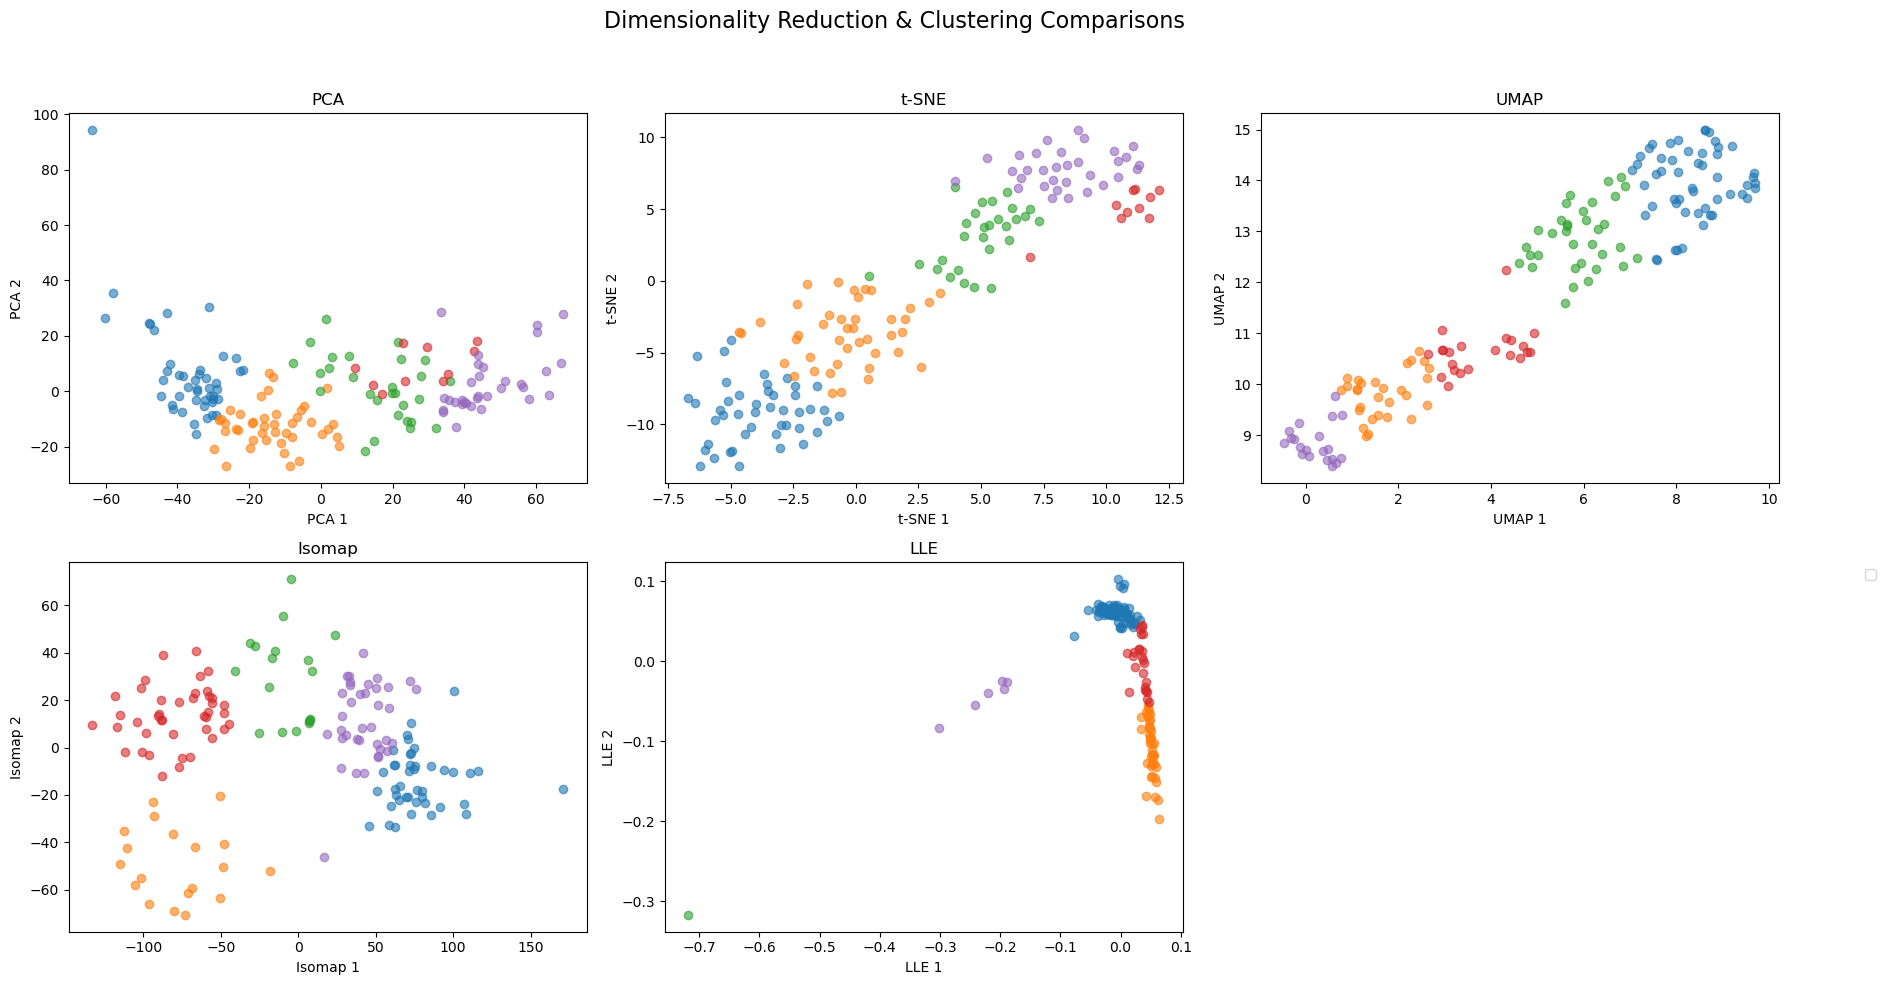

In [23]:
import matplotlib.pyplot as plt

# Setup: subplot grid
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

# Plot 1: PCA
for cid in sorted(df_strong['cluster'].unique()):
    subset = df_strong[df_strong['cluster'] == cid]
    axs[0].scatter(subset['pca_1'], subset['pca_2'], label=f'C{cid}', alpha=0.6)
axs[0].set_title("PCA")
axs[0].set_xlabel("PCA 1"); axs[0].set_ylabel("PCA 2")

# Plot 2: t-SNE
for cid in sorted(df_strong['cluster'].unique()):
    subset = df_strong[df_strong['cluster'] == cid]
    axs[1].scatter(subset['tsne_1'], subset['tsne_2'], label=f'C{cid}', alpha=0.6)
axs[1].set_title("t-SNE")
axs[1].set_xlabel("t-SNE 1"); axs[1].set_ylabel("t-SNE 2")

# Plot 3: UMAP
for cid in sorted(df_strong['umap_cluster'].unique()):
    subset = df_strong[df_strong['umap_cluster'] == cid]
    axs[2].scatter(subset['umap_1'], subset['umap_2'], label=f'C{cid}', alpha=0.6)
axs[2].set_title("UMAP")
axs[2].set_xlabel("UMAP 1"); axs[2].set_ylabel("UMAP 2")

# Plot 4: Isomap
for cid in sorted(df_strong['isomap_cluster'].unique()):
    subset = df_strong[df_strong['isomap_cluster'] == cid]
    axs[3].scatter(subset['isomap_1'], subset['isomap_2'], label=f'C{cid}', alpha=0.6)
axs[3].set_title("Isomap")
axs[3].set_xlabel("Isomap 1"); axs[3].set_ylabel("Isomap 2")

# Plot 5: LLE
for cid in sorted(df_strong['lle_cluster'].unique()):
    subset = df_strong[df_strong['lle_cluster'] == cid]
    axs[4].scatter(subset['lle_1'], subset['lle_2'], label=f'C{cid}', alpha=0.6)
axs[4].set_title("LLE")
axs[4].set_xlabel("LLE 1"); axs[4].set_ylabel("LLE 2")

# Hide last empty subplot
axs[5].axis('off')

# Final tweaks
fig.suptitle("Dimensionality Reduction & Clustering Comparisons", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


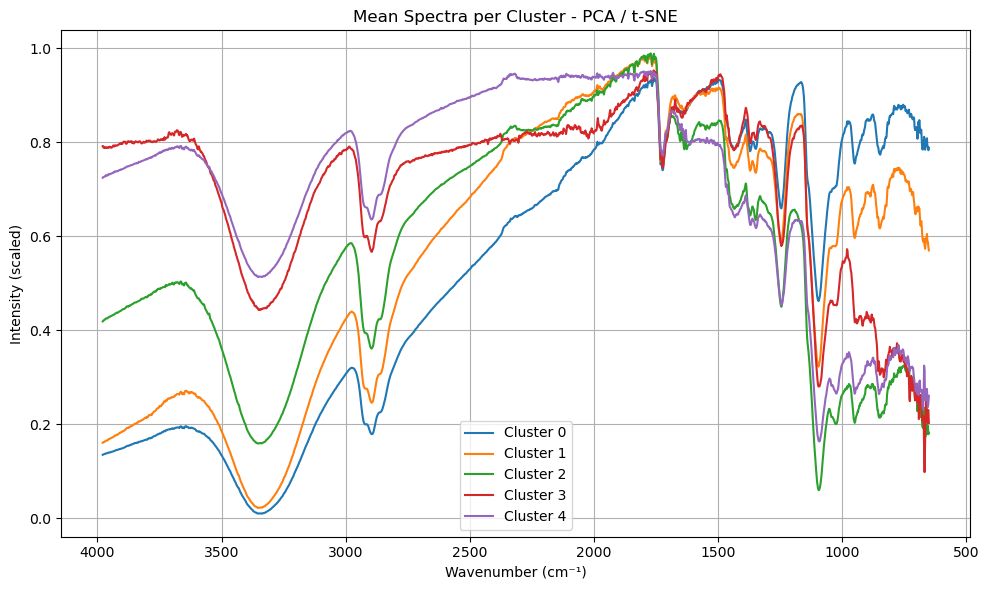

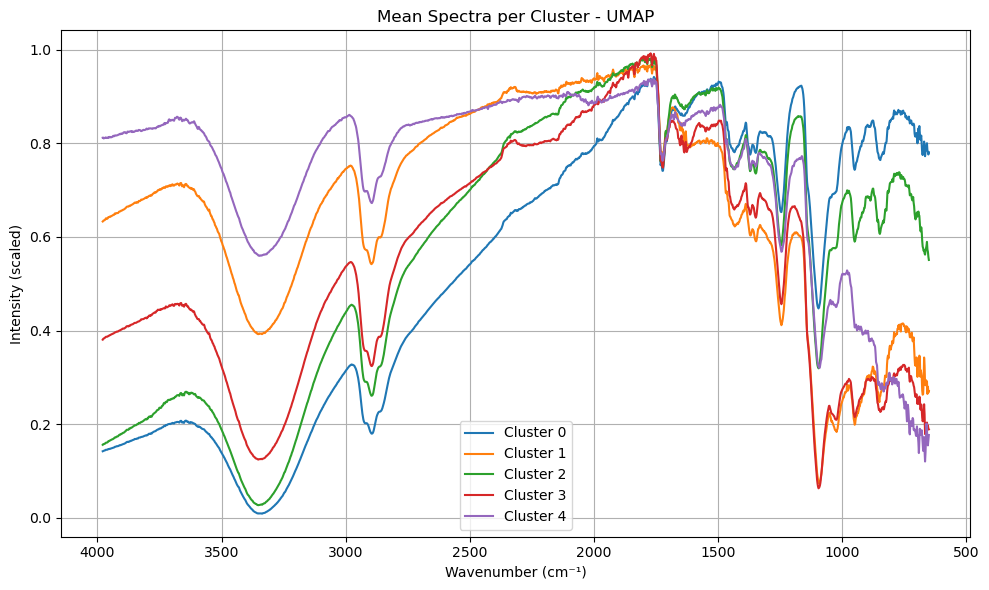

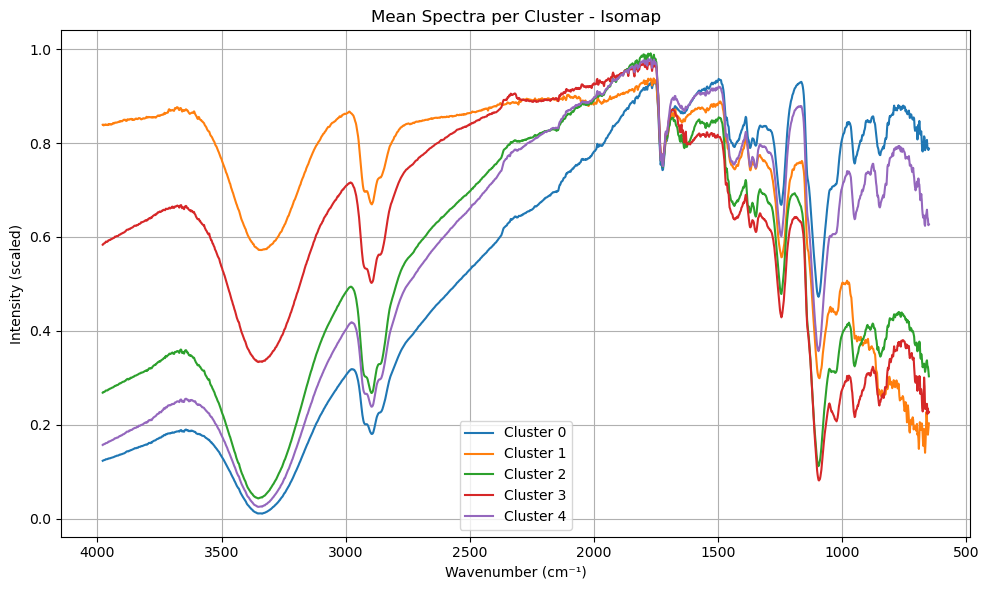

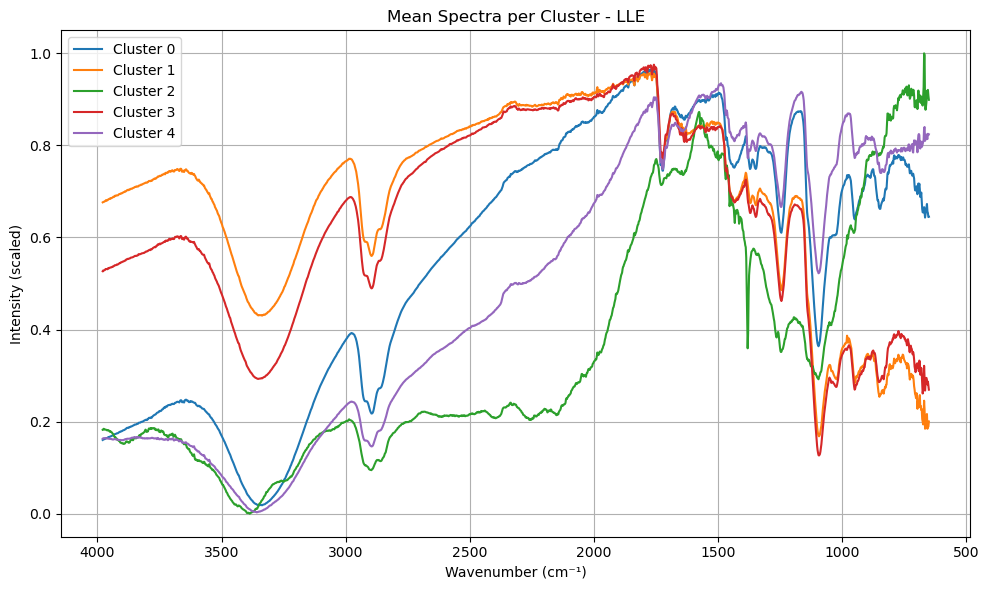

In [24]:
import matplotlib.pyplot as plt

# Define spectral columns and wavenumber axis
spectral_columns = [col for col in df_strong.columns if col.replace('.', '', 1).isdigit()]
wavenumbers = [float(w) for w in spectral_columns]

# Function to plot mean spectra by cluster type
def plot_mean_spectra(cluster_column, title):
    plt.figure(figsize=(10, 6))
    for cluster_id in sorted(df_strong[cluster_column].unique()):
        cluster_data = df_strong[df_strong[cluster_column] == cluster_id]
        mean_spectrum = cluster_data[spectral_columns].apply(pd.to_numeric, errors='coerce').mean()
        plt.plot(wavenumbers, mean_spectrum, label=f'Cluster {cluster_id}')
    plt.title(f"Mean Spectra per Cluster - {title}")
    plt.xlabel("Wavenumber (cm⁻¹)")
    plt.ylabel("Intensity (scaled)")
    plt.gca().invert_xaxis()
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all cluster-based mean spectra
plot_mean_spectra('cluster', 'PCA / t-SNE')
plot_mean_spectra('umap_cluster', 'UMAP')
plot_mean_spectra('isomap_cluster', 'Isomap')
plot_mean_spectra('lle_cluster', 'LLE')
